# Домашнее задание №3
Домашнее задание включает в себя следующие пункты:
1. Написать собственную свертку
2. Написать модуль батч нормализации для картинок
3. Написать модули для оптимизации SGD+momentum, RMSProp, Adam
4. Построить графики и обучения и сделать выводы по сравнению обучения, c различными гиперпараметрами (коэффициент обучения и betas)
    * SGD, SGD+momentum, Adam
    
За все три задания 1 бал, срок выполнения 2 недели, после 0.5 бала.

# 1. Реализация собственной свертки
В этом пункте Вам нужно реализовать модуль необучаемой свертки 2D. Используем только библиотеку pytorch. Получаем на вход тензор размером $(B, C_{in}, H, W)$, на выходе получаем тензор $(B, C_{out}, H_{out}, W_{out})$.
$$
B \ - \ размерность\ батча. \\
H - высота. \\
W - ширина. \\
С - количество\ каналов \\
$$
Реализуем операцию свертки:
$$
\begin{equation*}
\text{out}(B_i, C_{out_j}) = \text{bias}(C_{out_j}) +
                        \sum_{k = 0}^{C_{in} - 1} \text{kernel}(C_{out_j}, k) \star \text{x}(B_i, k)
\end{equation*},
$$

где $\large k $ - ядро свертки, с парамерами $C_{in}, H_k, W_k, stride_{H,W}, padding_{H,W}  $.

Формулы расчета размера выходной картинки
$$
\begin{align}\begin{aligned}H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}_H- \text{kernel_size}_H}{\text{stride}_H} + 1\right\rfloor\\W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}_W - \text{kernel_size}_W}{\text{stride}_W} + 1\right\rfloor\end{aligned}\end{align}
$$
Графическое представление 2D свертки
### Представление свертки
Параметры: kernel=3x3, padding=0,0
<img src="./imgs/18.jpg">

### Stride
Параметры: kernel=2x2, padding=0,0, stride=2,2
<img src="./imgs/22.gif" width=300>

### Padding
Параметры: kernel=2x2, padding=1,1, stride=1,1
<img src="./imgs/23.gif" width=400>



### Для проверки работоспособности сверки можно использовать 

```python 
from torch.nn.functional import conv2d
```
### Добавление дополнительной размерности в тензор
B - размер батча в нашем случае 1, размер картинки $C\times H \times W$. Для добавления и схлопывания размерностей используем
  - squeeze() - убирает размерность
  - unsqueeze() - добавляет размерность

In [1]:
def my_conv2d(x,
              kernel,
              stride=(1,1), padding=(0,0), bias=None):
    """
    Arguments:
    :param  x: входной тензор 4d, тип tensor.FloatTensor, размерность BxCxHxW
    :param  kernel: входной тензор ядра 3d, тип tensor.FloatTensor, CxHxW
    :param  stride: tuple - параметры страйда
    :param  padding:  tuple - параметры паддинга
    :param  bias : входной тензор bias добавляется к выходному тензору.  
    """
    
    result = torch.FloatTensor(int(x.size()[1] - kernel.size()[0] + 1),
                               int((x.size()[2] + 2 * padding[0] - kernel.size()[1]) / stride[0] + 1),
                               int((x.size()[3] + 2 * padding[1] - kernel.size()[2]) / stride[1] + 1))
    
    x.squeeze_(0)
    
    for k in range(result.size()[0]):
        for i in range(result.size()[1]):
            
            for j in range(result.size()[2]):
                
                ch0 = k
                ch1 = i * stride[0]
                ch2 = j * stride[1]
                
                part = x[ch0 : (ch0 + kernel.size()[0]), ch1 : (ch1 + kernel.size()[1]), ch2 : (ch2 + kernel.size()[2])]
                result[k, i, j] =  (part * kernel).sum()
    
    x.unsqueeze_(0) 
    
    if bias:
        return result + bias
    
    return result

## Тестируем функцию свертки

### Загружаем картинку 

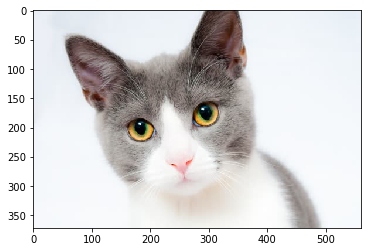

In [2]:
import torch
from torch.nn.functional import conv2d
import torchvision as tv
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
cat_convolve= Image.open('./imgs/cat_convolve.jpg')
plt.imshow(cat_convolve)

### Превращаем кота в тензор

In [3]:
cat_tensor = tv.transforms.ToTensor()(cat_convolve).unsqueeze(0)

### Сворачиваем картинку ядром, детектор границ
$$
\begin{bmatrix}
    -1       & -1 & -1  \\
    -1       & 8 & -1 \\
    -1       & -1 & -1
\end{bmatrix}
$$

### Создаем фильтр ядра и заполняем его -1 & 8

In [4]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(-1)
filter_kernel[:,1,1] = 8
print(filter_kernel.size())

torch.Size([3, 3, 3])


### Делаем свертку картинки ядром

torch.Size([1, 370, 558])


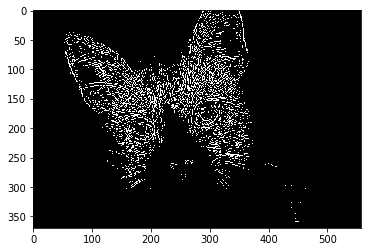

In [5]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
print(o_image.size())
plt.imshow(o_image.squeeze(0), cmap='gray')

### Горизонтальные границы
$$
\begin{bmatrix}
    1       & 1 & 1  \\
    0       & 0 & 0 \\
    -1       & -1 & -1
\end{bmatrix}
$$

In [6]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,1,:] = 0
filter_kernel[:,2,:] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([1, 370, 558])


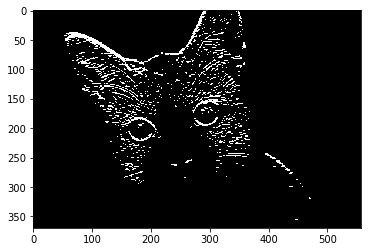

In [7]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
print(o_image.size())
plt.imshow(o_image.squeeze(0), cmap='gray')

### Вертикальные границы
$$
\begin{bmatrix}
    1       & 0 & -1  \\
    1       & 0 & -1 \\
    1       & 0 & -1
\end{bmatrix}
$$

In [8]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,:,1] = 0
filter_kernel[:,:,2] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([1, 370, 558])


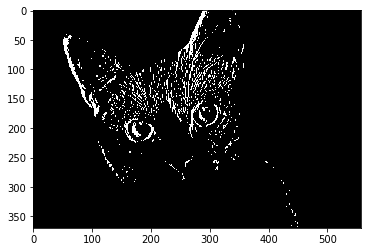

In [9]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
print(o_image.size())
plt.imshow(o_image.squeeze(0), cmap='gray')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 \\
    1 & 1
\end{bmatrix}$$

### и stride 2

torch.Size([1, 186, 280])


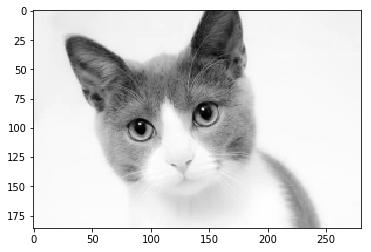

In [10]:
filter_kernelx2 = torch.FloatTensor(3,2,2).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(2,2))
o_image /= 4 # усредняем
print(o_image.size())
plt.imshow((o_image.squeeze(0)), cmap='gray')

### Ядро свертки с гауссовым распределением

torch.Size([3, 11, 11])


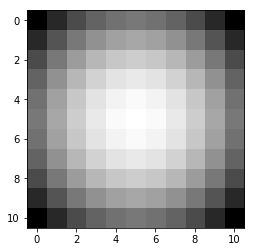

In [11]:
import scipy.ndimage as ndi
import numpy as np
sigma = 10    # параметр распределение
patern_size = 101 # максимальный размер ядра свертки
kernel_size = 10  # реальный размер свертки
x = np.zeros((patern_size, patern_size))
x [patern_size//2,patern_size//2]= 1

# делаем ядро с гауссовым распределением
gause_kernel = ndi.filters.gaussian_filter(x, sigma=sigma)
# вырезаем из центра наш кернел
gause_kernel = gause_kernel[(patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1, \
                (patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1]
# вот он
plt.imshow(gause_kernel, interpolation='none', cmap=plt.get_cmap('gray'))
gause_kernel = torch.from_numpy(gause_kernel).float().unsqueeze(0)
tmp = torch.FloatTensor (3, 11, 11)
for i in range (3):
    tmp[i] = gause_kernel
    
gause_kernel= tmp
print(gause_kernel.size())

# Делаем сверку 

torch.Size([1, 362, 550])


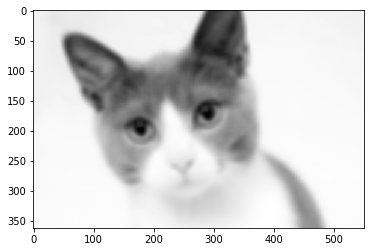

In [12]:
o_image = (my_conv2d(cat_tensor, gause_kernel))
print(o_image.size())
plt.imshow(o_image.squeeze(0), cmap='gray')

# 2. Написать модуль батч нормализации для картинок
<img src="./imgs/37.png" width=400>

- Как выглядит формула финальной батч нормализации в слое при прямом проходе в процессе тренеровки сети, используем формулу для экспоненциального скользящего среднего:
$$
\large
\begin{align}
v_t = \beta \times v_{t-1} + (1-\beta)\times \mu_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ среднее \\ 
s_t = \beta \times s_{t-1} + (1-\beta)\times \sigma^2_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ дисперсию \\ \\
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - v_t}{ \sqrt{s_t + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя
\end{align}
$$

где $ \large \gamma, b $ - параметры, афинного преобразования, размерность - количество фичей во входном тензоре, эти параметры обучаются вместе с батч нормализацией

- Как выглядит правило для расчета выхода в процессе инференса:
$$
\large
\begin{align}
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - v_t}{ \sqrt{s_t + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя
\end{align}
$$

$\large s_t, v_t, \gamma, b $ - параметры расчитанные в процессе тренировки слоя.

### Задание:
Реализовать модуль 2d батч нормализации и проверить его работу на входных изображениях.

P.S. Каждый канал входной картинки считается отдельной фичёй

Нужные функции
```python
import torch
torch.zeros #- создать тензор заполненный нулями
torch.ones #- создать тензор заполненный единицами
torch.Tensor #- создать тензор(1, in_channels, 1, 1)
torch.mean, torch.var  #- среднее и дисперсия
x.uniform_ #- заполнить тензор случайными числами из равномерного распределения
y.expand_as(x) #- разширить тензор y до размера x, по расширяемым направлениям размерность тензора x должна быть равна 1 
```

In [13]:
import torch.nn as nn

class BatchNorm2d(nn.Module):
    
    def __init__(self, in_channels, affine=True, beta=0.9, eps=1e-8):
        """
        :param in_channels: количество входных каналов предыдущего слоя
        :param afine: делать ли афинное преобразование.
        :param beta: параметр сглаживания
        :param epsilon: параметр исключающий деление на ноль
        """
        super().__init__()
    
        self.beta = beta
        self.eps  = eps
        self.dim  = in_channels
        self.running_mean = torch.zeros(self.dim)
        self.running_var  = torch.ones(self.dim)
        self.iter = 1

        if affine:
            self.gamma = torch.FloatTensor(1).uniform_()
            self.bias  = torch.FloatTensor(1).uniform_()
        else:
            self.gamma = 1
            self.bias  = 0
        
    def forward(self, x):
        """
        Считаем параметры нормализации в режиме обучения, и нормализуем x в обоих режимах
        """
        y = torch.FloatTensor(x.size()[1], x.size()[0], x.size()[2], x.size()[3])
        
        if self.training:
            mean = (x.permute(1,0,2,3).reshape(x.size()[1], x.size()[0] * x.size()[2] * x.size()[3])).mean(1)
            var  = (x.permute(1,0,2,3).reshape(x.size()[1], x.size()[0] * x.size()[2] * x.size()[3])).var(1)
            
            self.running_mean = (1 - self.beta) * mean + self.beta * self.running_mean
            self.running_var  = (1 - self.beta) * var + self.beta * self.running_var

            self.iter += 1
            
        x = x.permute(1, 0, 2, 3)
        
        for i in range (self.dim):
            y[i] = (x[i] - self.running_mean[i]) / ((self.running_var[i] + self.eps) ** 0.5)
        
        x = x.permute(1, 0, 2, 3)
        y = y.permute(1, 0, 2, 3)
        
        return y * self.gamma + self.bias

### Проверяем работу батч нормализации

In [14]:
cat_tensor = tv.transforms.ToTensor()(cat_convolve).unsqueeze(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 372, 560])


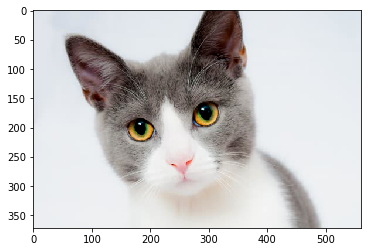

In [15]:
# Без афинных преобразований, за один проход не должно быть значительных изменений, потому что начальные значеня среднего 0 
# и дисперсии 1 
bn = BatchNorm2d(3, affine=False)
# добавляем размерность батча
o_image = bn(cat_tensor)
# убираем размерность батча
print (o_image.size())
plt.imshow(o_image.squeeze(0).permute(1, 2, 0))

torch.Size([3, 372, 560])


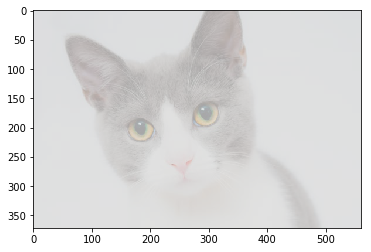

In [16]:
# C афинными преобразованиями, должен нагладыватья uniform_ шум при каждом новом запуске
bn = BatchNorm2d(3, affine=True)
# добавляем размерность батча
o_image = bn(cat_tensor)
# убираем размерность батча
o_image = o_image.squeeze(0)
print (o_image.size())
# для вывода картинки транспонируем тензор
plt.imshow(o_image.permute(1, 2, 0))

### Проверим как реализация работает на большом сете картинок

In [17]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [18]:
# Загружаем MNIST
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='./')
X = mnist['data']
# переходим к формату тензоров pytorch
X = X.reshape((-1, 1, 28, 28))
X = X.astype('float')
print(X.shape)

(70000, 1, 28, 28)


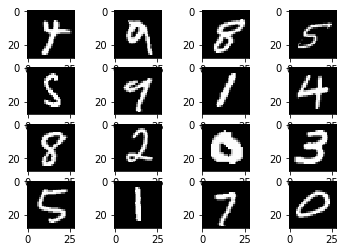

In [19]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    plt.imshow(I, cmap='gray')

### Тестируем модуль батч нормализации на мнисте
Прогоняем весь поток картинок (1 эпоха) с размером батча 32, и смотрим как расчитываются средние значения в процессе тренировки

In [20]:
# функция тестирования BN
def test_batch_norm(bn):
    bn.train(True)
    # количество эпох и размер батча
    c_epoch = 1
    batch_size = 32
    # данные для отчета
    mean_curve = []
    var_curve = []
    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            bn(x)
            mean_curve += [ bn.running_mean ] 
            var_curve +=  [ bn.running_var ]
    return mean_curve, var_curve

In [21]:
# параметры beta = 0.9, 0.99, 0.5
bn_09 = BatchNorm2d(1, beta=0.9)
bn_099 = BatchNorm2d(1, beta=0.99)
bn_05 = BatchNorm2d(1, beta=0.5)
# ставим обучение в True
bn.train(True)
# количество эпох и размер батча
c_epoch = 1
batch_size = 32
# данные для отчета
mean_curve_09, var_curve_09 = test_batch_norm(bn_09)
mean_curve_099, var_curve_099 = test_batch_norm(bn_099)
mean_curve_05, var_curve_05 = test_batch_norm(bn_05)

Смотрим какие значения средних и дисперсий у нас получились

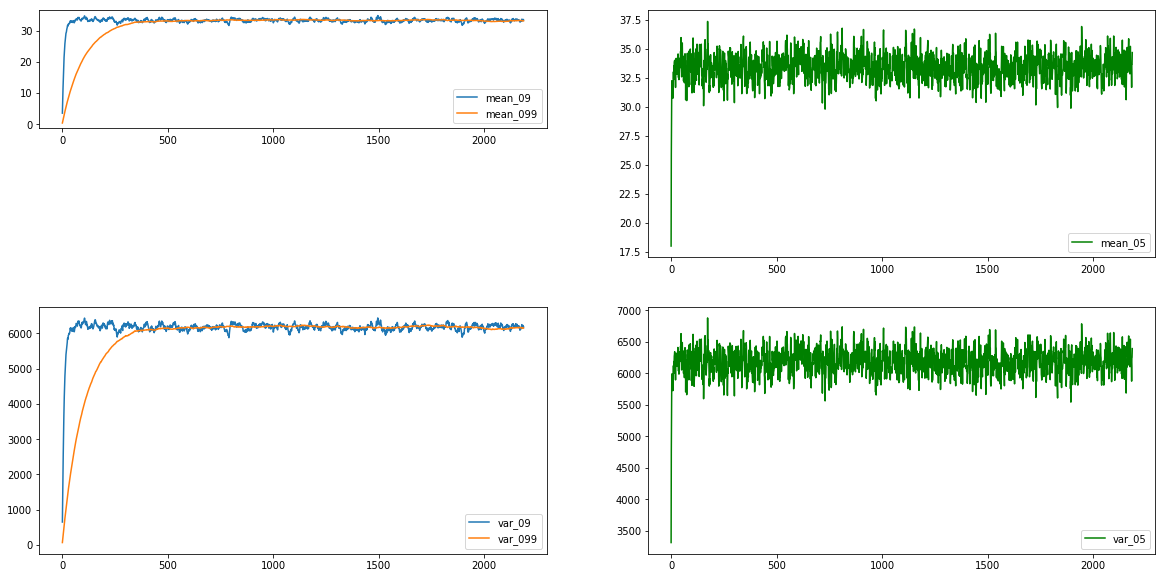

In [22]:
plt.figure(figsize=(20,10))
ax = plt.subplot(4,2,1)
ax.plot(mean_curve_09,label="mean_09")
ax.plot(mean_curve_099,label="mean_099")
ax.legend()
ax = plt.subplot(2,2,2)
ax.plot(mean_curve_05,label="mean_05",  color='g')
ax.legend()
ax = plt.subplot(2,2,3)
ax.plot(var_curve_09,label="var_09",)
ax.plot(var_curve_099,label="var_099",)
ax.legend()
ax = plt.subplot(2,2,4)
ax.plot(var_curve_05,label="var_05",  color='g')
ax.legend()

Посмотрим как повлияла батч нормализация на изображения

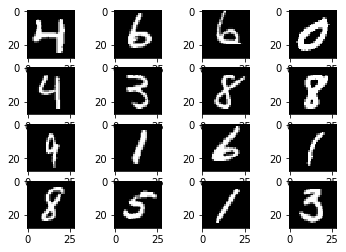

In [23]:
n=4
bn = bn_09
bn.train(False)
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    x = torch.Tensor(I)
    I = bn(x.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze()
    plt.imshow(I, cmap='gray')

## Done

# Реализуем свой Adam и SGD c моментом

Для реализации своего алгоритма оптимизации в pytorch нужно отнаслеловаться от базового класса Optimizer. При начальной инициализации алгоритма оптимизации он получает в качестве параматра все веса сети. Веса сети можно молучить через 
net.parameters(). По весам сети расчитывается градиент в функции loss.backward(). Веса сети организуются в группы, 
каждая группа образует словарь с сохраненными параметрами обучения, задаются в конструкторе, и самими параметрами, которые доступны по ключу "params". Параметры сети описываются классом Parameters. Для доступа к градиентам используется свойство grad.
Это тензор. Для сохранения параметров оптимизатор имеет свойство state, которое является словарем. Используется для
хранения промежуточных значений средних, дисперсий между шагами итераций.

**Задача** - реализовать функци step() для SGD и Adam, сравнить кривые обучения в зависимости от гиперпараметров (коэффициент обучения, betas), сделать выводы


## Adam (Adaptive Moment Estimation) 

Adam = SGD + Momentum + RMSProp

$$
\large
\begin{align}
m_t &= \alpha \times \ m_{t-1} + (1 - \alpha)\times g - момент \\ 
v_t &= \beta \times v_{t-1} +  (1-\beta)\times g_{t}^2  - скользящее\ среднее \ по \ квадрату \ градиента \\
\\
\hat{m_t} &= \frac{m_t}{1 - \alpha^t}\\
\hat{v_t} &= \frac{v_t}{1 - \beta^t}\\
\theta_t &= \theta_{t-1} -  \frac{\lambda}{\sqrt{\hat{v_t} + \epsilon}}\times \hat{m_t} \\
\ выразим\ step\_size \ через \ \alpha \ и \ \beta \\
\ step\_size =  \lambda \frac {({1 - \beta^t})^\frac{1}{2}}{{1 - \alpha^t}} \\ 
\theta_t &= \theta_{t-1} -  \frac{step\_size}{\sqrt{v_t + \epsilon}}\times m_t 
\end{align}
$$

Полезные функции

```python
import torch
torch.zeros_like(x)  # сделать тензор нулей такойже как x
tensor.addcmul_, addcdiv_, mul_  # все функции операции с тензорами, которые заканчиваются на _ присваивают результат в self тензор 
```


In [24]:
from torch.optim import Optimizer
import math

class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        """
        :param params: - параметры оптимизируемой сети
        :param betas: - коэффициенты сглаживания
        :param eps: - 
        """
        defaults = dict(lr=lr, betas=betas, eps=eps)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups
        super(Adam, self).__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """
        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе
            beta1, beta2 = group['betas']
            eps = group['eps']
            lr = group['lr']
            
            for p in group['params']:
                # итерируемся по всем парамерам в данной группе
                if p.grad is None:
                    continue
                    
                # забираем тензор градиента    
                grad = p.grad.data
              
                # тут храняться значения, которые мы расчитываем в процессе 
                # по каждому параметру в группе нужно расчитывать свои значения
                state = self.state[p]

                if len(state) == 0:
                    state['step']   = 1
                    state['avg']    = grad
                    state['avg_sq'] = grad ** 2
                    
                else:
                    state['avg']    = beta1 * state['avg']    + (1 - beta1) * grad
                    state['avg_sq'] = beta2 * state['avg_sq'] + (1 - beta2) * (grad ** 2)
                    
                step_size = lr * ((1 - beta2 ** state['step']) ** 0.5) / (1 - beta1 ** state['step'])
                        
                state['step'] += 1

                # обновляем веса в p.data, 
                p.data -= step_size * state['avg'] / ((state['avg_sq'] + eps) ** 0.5)

        return loss

## SGD + Momentum
$$
\Large
\begin{align}
g_t &= \nabla_{\theta} \overset{\wedge}{\large J}\left(x,y,\theta \right) - градиент \\
m_t &= \beta \times m_{t-1} - (1- \beta) \times g_t, \ где \  \beta - параметр\ обучения \\
m_t &= \alpha \times m_{t-1} - \lambda \times g_t, \ альтернативная \ форма \ записи \\
\theta_t &= \theta_{t-1} + m_t
\end{align}
$$

In [25]:

class SGD(Optimizer):
    def __init__(self, params, lr, beta=0.9):
        """
        :param params: - параметры оптимизируемой сети
        :param beta: - коэффициент сглаживания, если 0, получаем обычный SGD
        :param eps: - 
        """        
        defaults = dict(lr=lr, beta=beta)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups 
        super(SGD, self).__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """

        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе            
            beta = group['beta']
            lr = group['lr']
            
            for p in group['params']:
                if p.grad is None:
                    continue
                    
                grad = p.grad.data
                
                state = self.state[p]
                
                if beta != 0:
                    if 'moment' not in group:
                        state['moment'] = grad
                         
                    state['moment'] = beta * state['moment'] + (1 - beta) * grad
                    grad = state['moment']

                p.data -= lr * grad

        return loss

Тут векторизуем наш выход как OneHotEncoder вектор. Если объект принадлежит классу значение 1 нет 0.

In [31]:
from sklearn.preprocessing import OneHotEncoder

Y = mnist['target'].astype('int')
print('original', Y)


original [0 0 0 ... 9 9 9]


In [32]:
USE_CUDA=False

## Определение нашей модели
Параметры инициализации
- Без параметров - конволюции и активации
- dropout = True - c dropout
- batchnorm = True - включаем  batch normalization

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    # Слои, в которых нет параметров для обучения можно не создавать, а брать из переменной F
    def __init__(self, dropout=False, batchnorm=False):
        super(Net, self).__init__()

        # спецальный модуль, который позволяет 
        # объединять компоненты
        self.net = nn.Sequential(nn.BatchNorm2d(1))
        
        # вход 28x28, выход 24x24 (28-5)/1 + 1 = 24
        self.net.add_module('conv_1', nn.Conv2d(1, 8, kernel_size=5, stride=1))
        self.net.add_module('relu_1', nn.ReLU())  
        
        # добавляем дропаут и бн
        if batchnorm: self.net.add_module('bn_1', nn.BatchNorm2d(8))
        if dropout: self.net.add_module('do_1', nn.Dropout(0.5))
        
        # конволюция, которая уменьшает размер картинки в два раза 
        # (24+2-3)/2+1 = 13, либо используем nn.MaxPool2d
        self.net.add_module('pool_1', nn.Conv2d(8, 8, kernel_size=2, stride=2)) 
        
        # далее conv->relu->pool
        self.net.add_module('conv_2', nn.Conv2d(8, 16, 5)) # in 12x12, out 8x8
        self.net.add_module('relu_2', nn.ReLU() ) 
        
        # добавляем дропаут и бн
        if batchnorm: self.net.add_module('bn_2', nn.BatchNorm2d(16))
        if dropout: self.net.add_module('do_2', nn.Dropout(0.5))
            

        self.net.add_module('pool_2', nn.MaxPool2d(kernel_size=2, stride=2))                  
        self.fc1 = nn.Linear(16 * 4 * 4, 10)
        # relu

    def forward(self, x):
        x = self.net(x)
        # Вытягиваем многомерный тензор катринки в одну линию
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        x = F.relu(x)
        return x

## Функция обучения модели

In [40]:
def fit_net(c_epoch, network, optimizer):
    loss_fn = torch.nn.CrossEntropyLoss()
    if USE_CUDA:
        loss_fn = loss_fn.cuda()

    batch_size = 32
    loss_curve = []

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            optimizer.zero_grad()  
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            y = torch.from_numpy(Y[batch_idxs]).long()
            if USE_CUDA:
                x = x.cuda()
                y = y.cuda()
            y_pred = network(x)
            loss = loss_fn(y_pred, y)
            loss_acc += float( loss[0] )
            loss.backward() # <-- тут расчитывается градиент
            optimizer.step()  # <-- тут происходит обновление весов
        avg_epoch_loss = loss_acc / (nbatches)
        print(f'Epoch {iter}:\tloss {avg_epoch_loss}')
        loss_curve.append(avg_epoch_loss)
    
    return loss_curve

## SGD без момента

In [41]:
loss_curve_sgd = list()

for i in range(3):
    learning_rate = 10 ** (- i - 1)
    print (f'\tlearning rate = {learning_rate}\n')
    net = Net(batchnorm=True) # инициализация сети
    optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0) # создаем оптимизатор с параметрами
    loss_curve_sgd.append(fit_net(25, net, optimizer)) # обучаем сеть

	learning rate = 0.1



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 0:	loss 0.10726693574770106
Epoch 1:	loss 0.04600761886336894
Epoch 2:	loss 0.03495471627133374
Epoch 3:	loss 0.03025677852642607
Epoch 4:	loss 0.025703731592136483
Epoch 5:	loss 0.02309340907317839
Epoch 6:	loss 0.01973595836757251
Epoch 7:	loss 0.017859282691728377
Epoch 8:	loss 0.01570315109536045
Epoch 9:	loss 0.015314456615401121
Epoch 10:	loss 0.013715198259267515
Epoch 11:	loss 0.012342236956532927
Epoch 12:	loss 0.010934591354656612
Epoch 13:	loss 0.01084214345022702
Epoch 14:	loss 0.0092212181311794
Epoch 15:	loss 0.008733026196164086
Epoch 16:	loss 0.007134712261591102
Epoch 17:	loss 0.0070810346064853185
Epoch 18:	loss 0.007490611738628811
Epoch 19:	loss 0.0060936476154637
Epoch 20:	loss 0.0057955740805788565
Epoch 21:	loss 0.005481199922221514
Epoch 22:	loss 0.0048395598185460315
Epoch 23:	loss 0.004288660039572505
Epoch 24:	loss 0.005705366695532256
	learning rate = 0.01

Epoch 0:	loss 0.26917490924554816
Epoch 1:	loss 0.07537836681627279
Epoch 2:	loss 0.059247349903

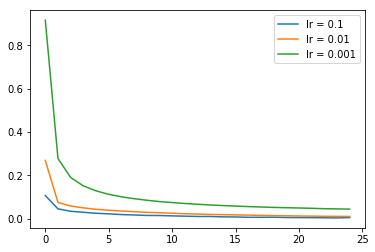

In [44]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd[0],label="lr = 0.1")
ax.plot(loss_curve_sgd[1],label="lr = 0.01")
ax.plot(loss_curve_sgd[2],label="lr = 0.001")
ax.legend()

## SGD с моментом

In [47]:
loss_curve_sgd_momentum = list()
betas = (0.5, 0.9, 0.99)
for i in range(3):
    learning_rate = 10 ** (- i - 1)
    for beta in betas:
        print (f"\tlr = {learning_rate}; beta = {beta}")
        net = Net(batchnorm = True)
        optimizer = SGD(net.parameters(), lr = learning_rate, beta = beta)
        loss_curve_sgd_momentum.append(fit_net(25, net, optimizer))

	lr = 0.1; beta = 0.5


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 0:	loss 0.1288093043228072
Epoch 1:	loss 0.053916213798043275
Epoch 2:	loss 0.04211655464559916
Epoch 3:	loss 0.0361089256899129
Epoch 4:	loss 0.031390040131753366
Epoch 5:	loss 0.027937292224831052
Epoch 6:	loss 0.02573607754001456
Epoch 7:	loss 0.02355693460573712
Epoch 8:	loss 0.020980745427920278
Epoch 9:	loss 0.019408016051257315
Epoch 10:	loss 0.018410875991320685
Epoch 11:	loss 0.016289357741537516
Epoch 12:	loss 0.015474898951016555
Epoch 13:	loss 0.014228893678156709
Epoch 14:	loss 0.013577900707694456
Epoch 15:	loss 0.01303757176613993
Epoch 16:	loss 0.011343207869510102
Epoch 17:	loss 0.01059399670902103
Epoch 18:	loss 0.010120538288619238
Epoch 19:	loss 0.00943679761466884
Epoch 20:	loss 0.008559813190662104
Epoch 21:	loss 0.00820842956605435
Epoch 22:	loss 0.008701224263312886
Epoch 23:	loss 0.00740774471873173
Epoch 24:	loss 0.006050682021539179
	lr = 0.1; beta = 0.9
Epoch 0:	loss 0.1268520874653061
Epoch 1:	loss 0.047445103999654833
Epoch 2:	loss 0.0357900651169248

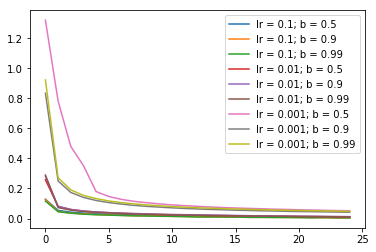

In [48]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd_momentum[0],label="lr = 0.1; b = 0.5")
ax.plot(loss_curve_sgd_momentum[1],label="lr = 0.1; b = 0.9")
ax.plot(loss_curve_sgd_momentum[2],label="lr = 0.1; b = 0.99")
ax.plot(loss_curve_sgd_momentum[3],label="lr = 0.01; b = 0.5")
ax.plot(loss_curve_sgd_momentum[4],label="lr = 0.01; b = 0.9")
ax.plot(loss_curve_sgd_momentum[5],label="lr = 0.01; b = 0.99")
ax.plot(loss_curve_sgd_momentum[6],label="lr = 0.001; b = 0.5")
ax.plot(loss_curve_sgd_momentum[7],label="lr = 0.001; b = 0.9")
ax.plot(loss_curve_sgd_momentum[8],label="lr = 0.001; b = 0.99")
ax.legend()

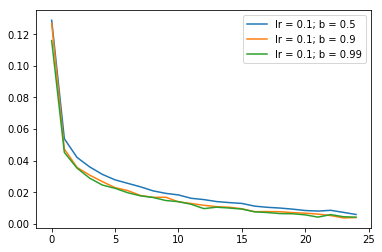

In [49]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd_momentum[0],label="lr = 0.1; b = 0.5")
ax.plot(loss_curve_sgd_momentum[1],label="lr = 0.1; b = 0.9")
ax.plot(loss_curve_sgd_momentum[2],label="lr = 0.1; b = 0.99")
ax.legend()

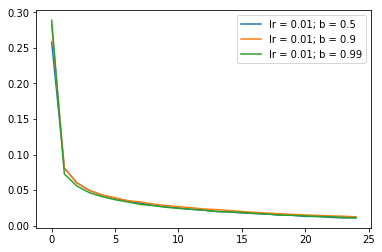

In [50]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd_momentum[3],label="lr = 0.01; b = 0.5")
ax.plot(loss_curve_sgd_momentum[4],label="lr = 0.01; b = 0.9")
ax.plot(loss_curve_sgd_momentum[5],label="lr = 0.01; b = 0.99")
ax.legend()

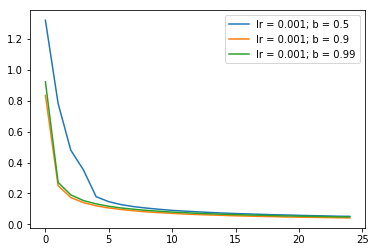

In [51]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd_momentum[6],label="lr = 0.001; b = 0.5")
ax.plot(loss_curve_sgd_momentum[7],label="lr = 0.001; b = 0.9")
ax.plot(loss_curve_sgd_momentum[8],label="lr = 0.001; b = 0.99")
ax.legend()

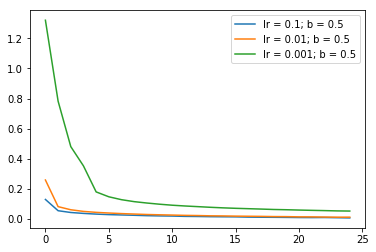

In [52]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd_momentum[0],label="lr = 0.1; b = 0.5")
ax.plot(loss_curve_sgd_momentum[3],label="lr = 0.01; b = 0.5")
ax.plot(loss_curve_sgd_momentum[6],label="lr = 0.001; b = 0.5")
ax.legend()

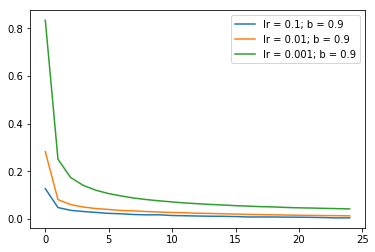

In [53]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd_momentum[1],label="lr = 0.1; b = 0.9")
ax.plot(loss_curve_sgd_momentum[4],label="lr = 0.01; b = 0.9")
ax.plot(loss_curve_sgd_momentum[7],label="lr = 0.001; b = 0.9")
ax.legend()

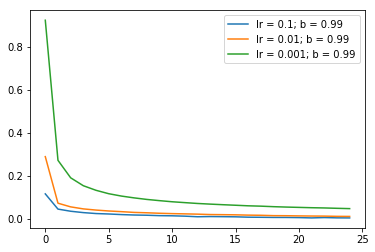

In [54]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd_momentum[2],label="lr = 0.1; b = 0.99")
ax.plot(loss_curve_sgd_momentum[5],label="lr = 0.01; b = 0.99")
ax.plot(loss_curve_sgd_momentum[8],label="lr = 0.001; b = 0.99")
ax.legend()

## Adam

In [55]:
loss_curve_adam = list()
betas_list = ((0.5, 0.5), (0.5, 0.999), (0.9, 0.5), (0.9, 0.9), (0.9, 0.999), (0.99, 0.5), (0.99, 0.9), (0.99, 0.999))
for i in range(2):
    learning_rate = 10 ** (- i - 2)
    for betas in betas_list:
        print (f"\tlr = {learning_rate}; betas = {betas}")
        net = Net(batchnorm = True)
        optimizer = Adam(net.parameters(), lr = learning_rate, betas = betas)
        loss_curve_adam.append(fit_net(20, net, optimizer))

	lr = 0.01; betas = (0.5, 0.5)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 0:	loss 0.7936678896034259
Epoch 1:	loss 0.7513044139921365
Epoch 2:	loss 0.7458617826221084
Epoch 3:	loss 0.7423288284042517
Epoch 4:	loss 0.739694295835157
Epoch 5:	loss 0.5972304396198447
Epoch 6:	loss 0.5104236993197715
Epoch 7:	loss 0.5094638832073589
Epoch 8:	loss 0.5079354166603001
Epoch 9:	loss 0.5055009007120056
Epoch 10:	loss 0.5050895047899137
Epoch 11:	loss 0.5067934134219627
Epoch 12:	loss 0.43683118690665473
Epoch 13:	loss 0.2841732167150394
Epoch 14:	loss 0.27827885896512566
Epoch 15:	loss 0.27218740042699324
Epoch 16:	loss 0.27152924107112564
Epoch 17:	loss 0.2699738445657271
Epoch 18:	loss 0.27192401867249155
Epoch 19:	loss 0.2676631339306585
	lr = 0.01; betas = (0.5, 0.999)
Epoch 0:	loss 0.1172186228807353
Epoch 1:	loss 0.05602434012488682
Epoch 2:	loss 0.05011418803156812
Epoch 3:	loss 0.0462354470945462
Epoch 4:	loss 0.04150925157996253
Epoch 5:	loss 0.0385070901089844
Epoch 6:	loss 0.03482194177748463
Epoch 7:	loss 0.03312075633775387
Epoch 8:	loss 0.03243569

Epoch 11:	loss 0.2242935336393802
Epoch 12:	loss 0.22276485920340763
Epoch 13:	loss 0.2221159355303551
Epoch 14:	loss 0.22091242764698735
Epoch 15:	loss 0.2199229667713558
Epoch 16:	loss 0.22000007521127748
Epoch 17:	loss 0.21842546934099244
Epoch 18:	loss 0.21804781450417743
Epoch 19:	loss 0.21819618454685918
	lr = 0.001; betas = (0.9, 0.999)
Epoch 0:	loss 0.20795480275180006
Epoch 1:	loss 0.051246948829785186
Epoch 2:	loss 0.03926736177730953
Epoch 3:	loss 0.0322071194996232
Epoch 4:	loss 0.028252216165857224
Epoch 5:	loss 0.025384804825832923
Epoch 6:	loss 0.021917586552535336
Epoch 7:	loss 0.020147595402989476
Epoch 8:	loss 0.0177286239004484
Epoch 9:	loss 0.016267846051857358
Epoch 10:	loss 0.01368790243211052
Epoch 11:	loss 0.013172134678686487
Epoch 12:	loss 0.012044629343552408
Epoch 13:	loss 0.012122348410847746
Epoch 14:	loss 0.010657797822627402
Epoch 15:	loss 0.010503050374232529
Epoch 16:	loss 0.008692257457200283
Epoch 17:	loss 0.008646810986868148
Epoch 18:	loss 0.008741

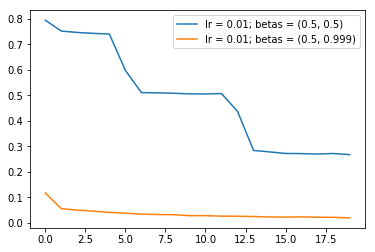

In [56]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_adam[0],label="lr = 0.01; betas = (0.5, 0.5)")
ax.plot(loss_curve_adam[1],label="lr = 0.01; betas = (0.5, 0.999)")
ax.legend()

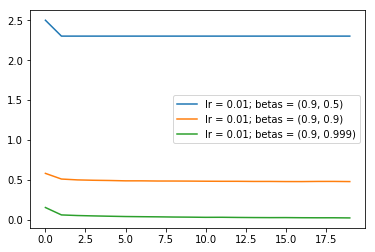

In [57]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_adam[2],label="lr = 0.01; betas = (0.9, 0.5)")
ax.plot(loss_curve_adam[3],label="lr = 0.01; betas = (0.9, 0.9)")
ax.plot(loss_curve_adam[4],label="lr = 0.01; betas = (0.9, 0.999)")
ax.legend()

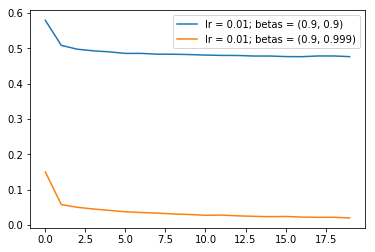

In [58]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_adam[3],label="lr = 0.01; betas = (0.9, 0.9)")
ax.plot(loss_curve_adam[4],label="lr = 0.01; betas = (0.9, 0.999)")
ax.legend()

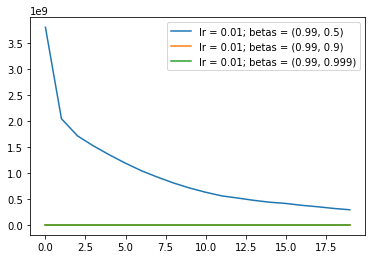

In [59]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_adam[5],label="lr = 0.01; betas = (0.99, 0.5)")
ax.plot(loss_curve_adam[6],label="lr = 0.01; betas = (0.99, 0.9)")
ax.plot(loss_curve_adam[7],label="lr = 0.01; betas = (0.99, 0.999)")
ax.legend()

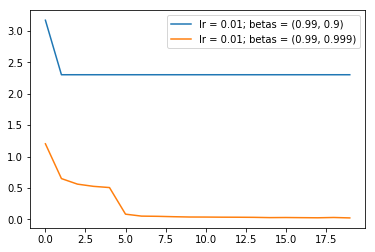

In [68]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_adam[6],label="lr = 0.01; betas = (0.99, 0.9)")
ax.plot(loss_curve_adam[7],label="lr = 0.01; betas = (0.99, 0.999)")
ax.legend()

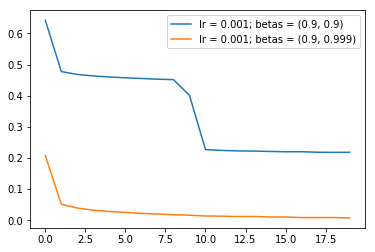

In [65]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_adam[11],label="lr = 0.001; betas = (0.9, 0.9)")
ax.plot(loss_curve_adam[12],label="lr = 0.001; betas = (0.9, 0.999)")
ax.legend()

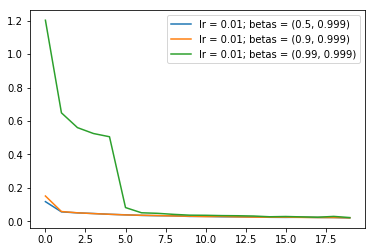

In [71]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_adam[1],label="lr = 0.01; betas = (0.5, 0.999)")
ax.plot(loss_curve_adam[4],label="lr = 0.01; betas = (0.9, 0.999)")
ax.plot(loss_curve_adam[7],label="lr = 0.01; betas = (0.99, 0.999)")
ax.legend()

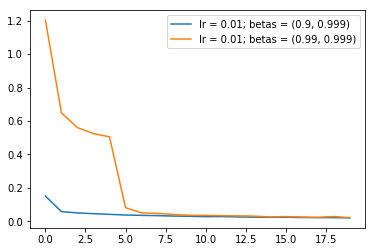

In [72]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_adam[4],label="lr = 0.01; betas = (0.9, 0.999)")
ax.plot(loss_curve_adam[7],label="lr = 0.01; betas = (0.99, 0.999)")
ax.legend()

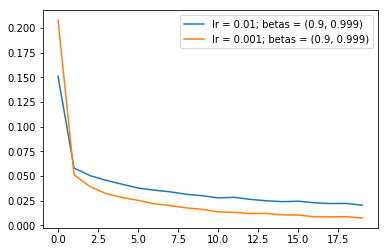

In [69]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_adam[4],label="lr = 0.01; betas = (0.9, 0.999)")
ax.plot(loss_curve_adam[12],label="lr = 0.001; betas = (0.9, 0.999)")
ax.legend()

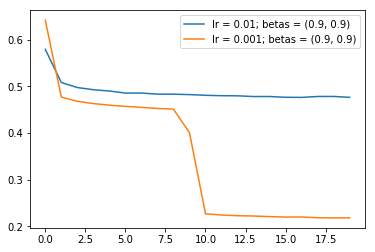

In [70]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_adam[3],label="lr = 0.01; betas = (0.9, 0.9)")
ax.plot(loss_curve_adam[11],label="lr = 0.001; betas = (0.9, 0.9)")
ax.legend()

# Кривые обучения

In [ ]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd,label="SGD")
ax.plot(loss_curve_sgd_momentum,label="SGD+Momentum")
ax.plot(loss_curve_adam, label='Adam' )
ax.legend()

### Выводы

_пишем выводы по сходимости и скорости обучения: Adam, SGD, SGD+momentum, с различными параметрами обучения lr и betas_

#### sgd без момента
чем ниже learning rate, тем дольше сходится функция; при слишком высоком learning rate функция сходится не будет (очевидно)

#### sgd с моментом
чем выше момент (beta), тем увереннее сходится функция; с learning rate ситуация схожа с sgd без момента

#### adam
с первой beta (для grad) ситуация схожа с beta для sgd с моментом; чем больше вторая beta (для grad ** 2), тем быстрее и увереннее сходится функция (все равно, что увеличть learning rate в sgd); чем ниже learning rate, тем лучше сходится функция 